In [1]:
# for data manipulation and processing
import numpy as np
import pandas as pd

# for text processing and NLP
import re
import nltk
from nltk.corpus import wordnet
import random
from sklearn.preprocessing import LabelBinarizer

# for machine Learning and Deep Learning training tasks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Attention, GlobalAveragePooling1D
from gensim.models import KeyedVectors

# for evaluation and Metrics
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#pour les clouds
from wordcloud import WordCloud

#pour enregistrement du modele 
import pickle
from tensorflow.keras.models import load_model

# for plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing

Chargement des données

In [2]:
df = pd.read_csv('bbc-text.csv')  

Filtrage des catégories

In [3]:
# enlever 'entertainment' des catégories
df = df[df['category'] != 'entertainment']

Suppression des doublons

In [4]:
initial_duplicate_count = df.duplicated().sum()
print(f"\nTotal number of duplicate rows: {initial_duplicate_count}")

df = df.drop_duplicates().reset_index(drop=True)

print(f"\nShape of DataFrame after removing duplicates: {df.shape}")



Total number of duplicate rows: 82

Shape of DataFrame after removing duplicates: (1757, 2)


Augmentation des données

In [5]:
# fonction qui remplace les mots par leurs synonymes
def augment_text_with_synonyms(text):
    words = nltk.word_tokenize(text) 
    augmented_text = []  # Liste avec texte modifier

    for word in words:
        synonyms = wordnet.synsets(word)  # synonyme du mot
        if synonyms:
            # prendre un synonyme random
            synonym_list = [lemma.name() for lemma in synonyms[0].lemmas()]
            augmented_text.append(random.choice(synonym_list))
        else:
            # si aucun synonyme pour le mot on le laisse
            augmented_text.append(word)

    return " ".join(augmented_text)  # Combineer le tout en une seule phrase

# This function makes multiple unique versions of the text by replacing words
def create_unique_augmentations(original_text, num_augmentations=3):
    augmentations = set()  # Use a set so there are no duplicates

    while len(augmentations) < num_augmentations:  # here we keep making new versions
        augmented_text = augment_text_with_synonyms(original_text)
        augmentations.add(augmented_text)  # Adds it to the set
    
    return list(augmentations)  # Return the final list of unique versions


In [6]:
# Adding more data by creating augmented text
augmented_data = [
    {'text': aug_text, 'category': row['category']}  # Creates a new row for each augmented text
    for _, row in df.iterrows()  # Loops through each row in the original DataFrame
    for aug_text in create_unique_augmentations(row['text'], num_augmentations=3)  # Creates 3 new versions of the text
]

# Making a DataFrame from the augmented data and combine it with the original data
augmented_df = pd.DataFrame(augmented_data)  # Turning the augmented list into a DataFrame
df = pd.concat([df, augmented_df]).reset_index(drop=True)  

print(f"Shape of the augmented DataFrame: {df.shape}")

# Removing duplicate rows just in case there are repeats
df = df.drop_duplicates().reset_index(drop=True)


Shape of the augmented DataFrame: (7028, 2)


In [7]:
print(f"SHAPE OF DATASET: {df.shape}\n")
print(f"CATEGORIES: {df['category'].unique()}\n")
category_counts = df['category'].value_counts()
print("CATEGORIES counts ", category_counts)
print(f"SAMPLE DATA:\n{df.sample(5)}\n")


SHAPE OF DATASET: (7028, 2)

CATEGORIES: ['tech' 'business' 'sport' 'politics']

CATEGORIES counts  category
sport       2016
business    2012
politics    1612
tech        1388
Name: count, dtype: int64


SAMPLE DATA:
      category                                               text
1553  business  brussels raps mobile call charges the european...
5440  politics  best somebody for top legal business the best ...
2112  business  America seek new $ 280bn smoker ruling the Uni...
2750  business  Russian oil merger omit yukos the amalgamation...
4124  business  low-priced airline hit eurotunnel transmission...



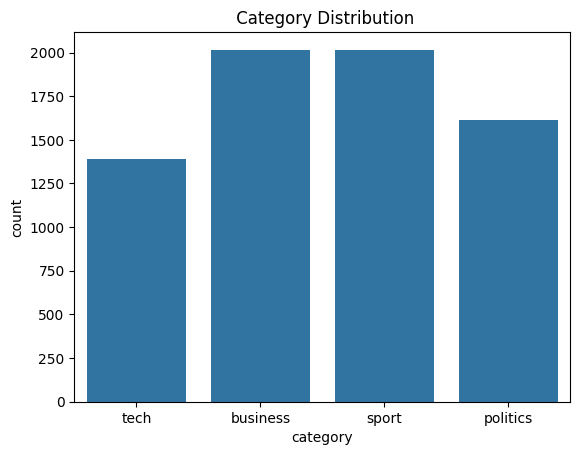

In [8]:
categories = df['category'].unique() 
# Plot the distribution of categories
sns.countplot(data=df, x='category')
plt.title(" Category Distribution")
plt.show()

Equilibrage des classes

In [9]:
categories = df['category'].unique() 
#Determine the target count for balancing
target_count = min(df['category'].value_counts())  # Minimum count among all categories
print(f"Target count for balancing: {target_count}\n")

# Creating a dictionary of DataFrames for each category
dfs = {category: df[df['category'] == category] for category in categories}

# Sampling each category to balance the dataset
for category in categories:
    # Sampling rows from each category with replacement if needed
    dfs[category] = dfs[category].sample(target_count, replace=True, random_state=42)

# Concatenate all sampled DataFrames to form the balanced dataset
df = pd.concat(dfs.values()).sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle and reset index

print(f"RÉPARTITION APRÈS ÉQUILIBRAGE :\n{df['category'].value_counts()}\n") 
print(f"SHAPE OF BALANCED DATASET: {df.shape}\n")  


Target count for balancing: 1388

RÉPARTITION APRÈS ÉQUILIBRAGE :
category
business    1388
sport       1388
tech        1388
politics    1388
Name: count, dtype: int64

SHAPE OF BALANCED DATASET: (5552, 2)



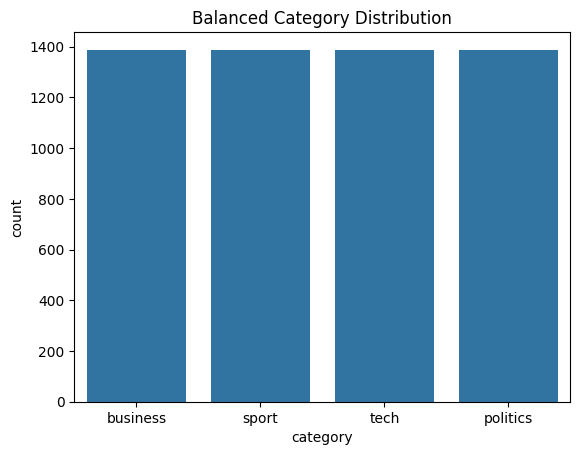

In [10]:
# Plot of the distribution of categories
sns.countplot(data=df, x='category')
plt.title("Balanced Category Distribution")
plt.show()


Nettoyage des textes

In [11]:
def clean_text(text):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    tokens = nltk.word_tokenize(text.lower()) 
    tokens = [
        lemmatizer.lemmatize(word)  
        for word in tokens
        if word.isalpha() and word not in stop_words  # Keep only alphabetic words not in stop words
    ]
    
    # Join the tokens into a cleaned text string
    return " ".join(tokens)



In [12]:
df['text_clean'] = df['text'].apply(clean_text)


Tokenization

In [13]:
# Initialize a tokenizer with a vocabulary size of 20,000 and an Out-of-Vocabulary (OOV) token
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_clean'])

Padding des séquences

In [14]:
# Convertir le texte en integers
sequences = tokenizer.texts_to_sequences(df['text_clean'])
# Define the maximum sequence length
max_length = 300
# Pad or truncate sequences to ensure all have the same length
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

Encodage des catégories

In [15]:
# Convert categories into numerical codes
df['category_code'] = df['category'].astype('category').cat.codes

# Extract the encoded labels as a NumPy array
y = df['category_code'].values


In [16]:
#ici c'est juste pour vérifier l'ordre des catégorie pour notre modèle
category_labels = df['category'].astype('category').cat.categories
print(category_labels)

Index(['business', 'politics', 'sport', 'tech'], dtype='object')


In [17]:
print(f"Shape of X (input sequences): {X.shape}")
print(f"Shape of y (labels): {y.shape}")

print("\nTokenized and Padded Sequences (X):")
print(X[:3])

print("\nEncoded Labels (y):")
print(y[:3])



Shape of X (input sequences): (5552, 300)
Shape of y (labels): (5552,)

Tokenized and Padded Sequences (X):
[[ 4825 10999  9380  2292  4825  2738  3943     6  1065   116    10    11
   2627   755  5110    89   721    13   158  3775  2950   253  1822   417
    577   118  4413    36   186   277  2978  2823   169  9381  7151     4
    557  1944    75  2042     2  2916   236   932     9   207  2978    10
   1265   144   173  3641   653   168  3775  2950    42  1099   418   158
   1710   868  3776  2884 13813  1189    21   567   169  2680  8569    18
   2950  4555  2790  2392   334   763  3775 17093   998    12  2056  2855
   1197  5988    87  2978 10411   746    83    11   770  9382  7942     4
     36    26  2308    76    56 10412  8916  1223   657   183   370     3
     89   487  2950    22    35  1155    26   307   844 17094  7152  1061
    249     2  4825  5826  4740   642  2137   192    38  2950     4   786
    371   249   580    13   192   702    58   341  1530     5  2791  8917
    

Séparation des données

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


Embedding avec word2vec

In [19]:
# Load pretrained Word2Vec model
word2vec_path = 'GoogleNews-vectors-negative300.bin' 
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Create embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [20]:
for word, i in tokenizer.word_index.items():
    # Check if the word is in the Word2Vec model's vocabulary
    if word in word2vec.key_to_index:
        # If the word is found, assign its Word2Vec vector to the embedding matrix
        embedding_matrix[i] = word2vec[word]


# Conception

Architecture du modèle

In [21]:
# Input layer 
input_layer = Input(shape=(max_length,))

# Embedding layer to convert words into vectors using the pre-trained Word2Vec embeddings
embedding_layer = Embedding(input_dim=vocab_size, 
                             output_dim=embedding_dim, 
                             weights=[embedding_matrix],  
                             input_length=max_length, 
                             trainable=False)(input_layer)  


lstm_layer = LSTM(128, return_sequences=True, dropout=0.2)(embedding_layer)

# Attention layer to focus on important parts of the sequence
attention_layer = Attention()([lstm_layer, lstm_layer])

# Pooling the attention layer output to get a fixed-size output
pooled_layer = GlobalAveragePooling1D()(attention_layer)

# Fully connected (dense) layer with 64 neurons and ReLU activation
dense_layer = Dense(64, activation='relu')(pooled_layer)

# Dropout layer to reduce overfitting
dropout_layer = Dropout(0.3)(dense_layer)

# Output layer with softmax activation for multi-class classification
output_layer = Dense(len(df['category'].unique()), activation='softmax')(dropout_layer)

# Creation of the model with input and output layers
model = Model(inputs=input_layer, outputs=output_layer)

# Compilation of the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Printing the model summary to check layers and parameters
model.summary()


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 300)  │  7,459,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300, 128)  │    219,648 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 300, 128)  │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,687,964 (29.33 MB)

 Trainable params: 228,164 (891.27 KB)

 Non-trainable params: 7,459,800 (28.46 MB)

Entrainement de modèle

In [22]:
history = model.fit(
    X_train, y_train,  # Training data and labels
    epochs=10,  # Number of epochs  for training
    batch_size=32,  # Size of data to be processed at once
    validation_split=0.2,  # Use 20% of data for validation during training
    class_weight=class_weights,  # Apply class weights to balance imbalanced classes
    verbose=1  # to display training progress
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.7110 - loss: 0.8203 - val_accuracy: 0.9336 - val_loss: 0.2001
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 478ms/step - accuracy: 0.9429 - loss: 0.1909 - val_accuracy: 0.9629 - val_loss: 0.1218
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 360ms/step - accuracy: 0.9571 - loss: 0.1273 - val_accuracy: 0.9719 - val_loss: 0.1044
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.9608 - loss: 0.1172 - val_accuracy: 0.9764 - val_loss: 0.1041
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.9738 - loss: 0.0975 - val_accuracy: 0.9618 - val_loss: 0.1137
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.9668 - loss: 0.0946 - val_accuracy: 0.9786 - val_loss: 0.0826
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.9706 - loss: 0.1026 - val_accuracy: 0.9831 - val_loss: 0.0670
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 358ms/step - accuracy: 0.9757 - loss: 0

# Evaluation

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)  # Evaluating using test set
print(f"Test Loss: {test_loss* 100:.2f}%") 
print(f"Test Accuracy: {test_accuracy* 100:.2f}%") 
# Extract training and validation accuracy for the last epoch
training_accuracy = history.history['accuracy'][-1]  
validation_accuracy = history.history['val_accuracy'][-1] 

print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9870 - loss: 0.0445
Test Loss: 5.11%
Test Accuracy: 98.47%
Training Accuracy: 98.68%
Validation Accuracy: 97.98%


Courbe de perte et précision

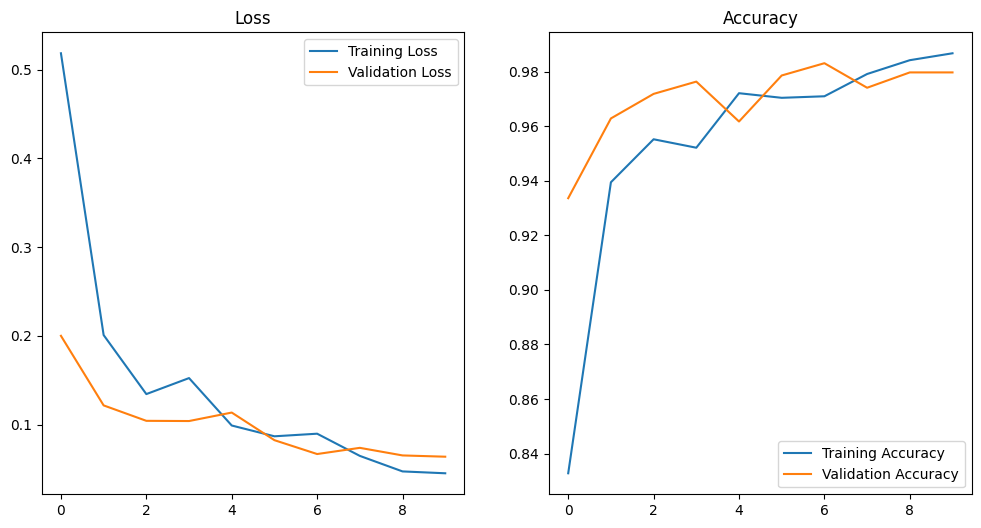

In [24]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)

Wordclouds

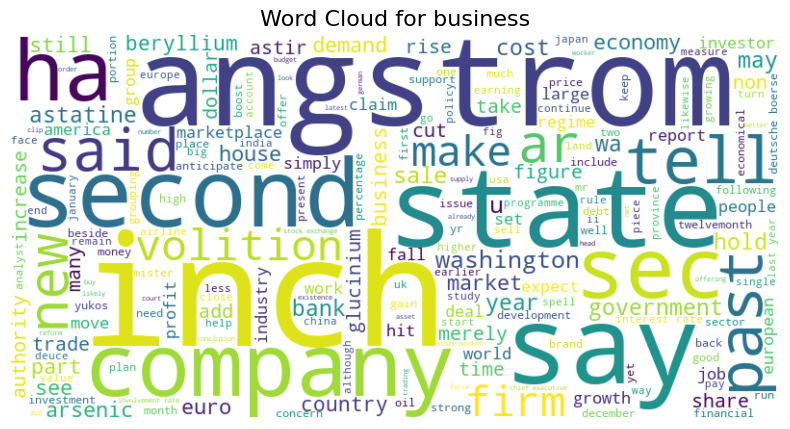

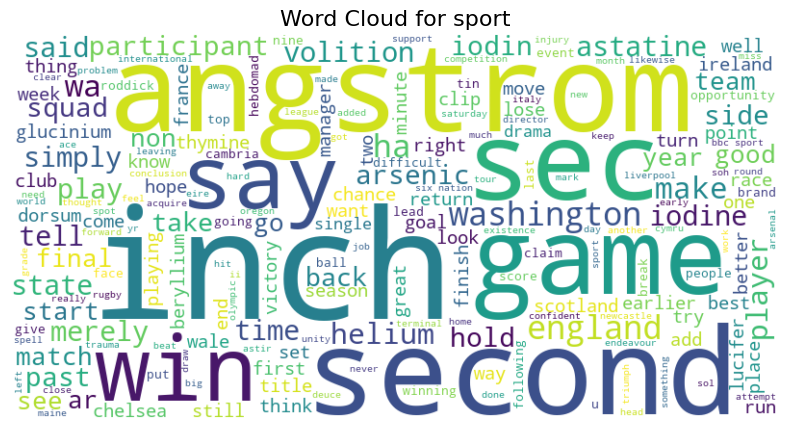

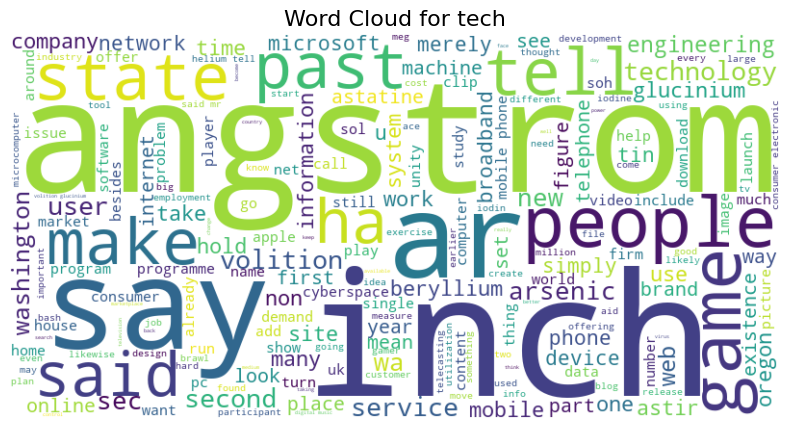

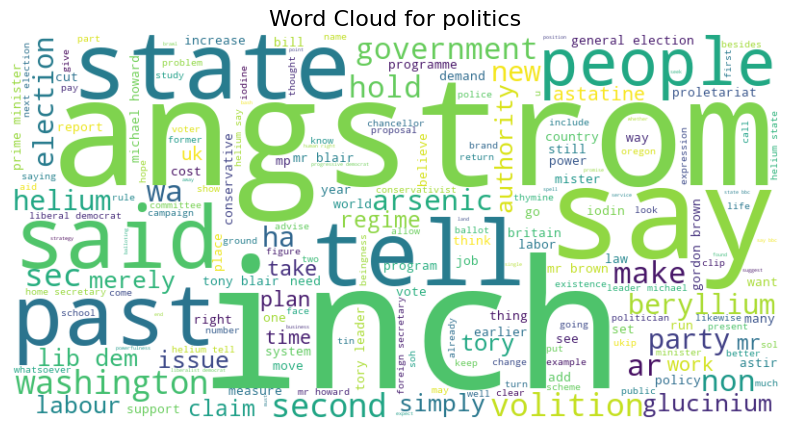

In [25]:
category_texts = {category: ' '.join(df[df['category'] == category]['text_clean']) for category in df['category'].unique()}

# Create and plot word clouds for each category
for category, text in category_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plotting the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {category}", fontsize=16)
    plt.axis('off')
    plt.show()


Matrice de confusion

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


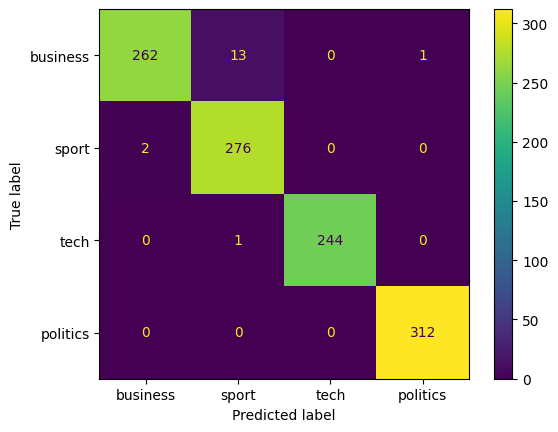

In [26]:
# Get the model's predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=df['category'].unique())
disp.plot(cmap='viridis')
plt.show()

F1 - Rappel - Précision

              precision    recall  f1-score   support

    business       0.99      0.95      0.97       276
       sport       0.95      0.99      0.97       278
        tech       1.00      1.00      1.00       245
    politics       1.00      1.00      1.00       312

    accuracy                           0.98      1111
   macro avg       0.99      0.98      0.98      1111
weighted avg       0.99      0.98      0.98      1111



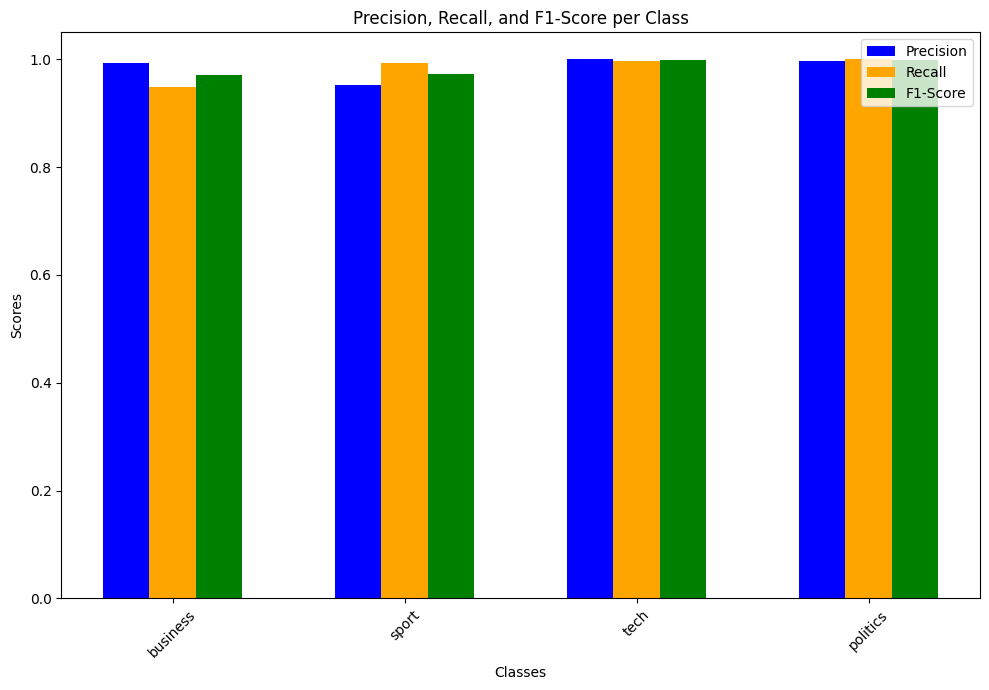

In [27]:
# Classification report (F1-score, Precision, Recall, Accuracy)
report = classification_report(y_test, y_pred_classes, target_names=df['category'].unique(), zero_division=1)
print(report)

#F1-Score, Precision, and Recall
f1 = f1_score(y_test, y_pred_classes, average=None)
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)

# Plotting F1-Score, Precision, and Recall
labels = df['category'].unique()
x = np.arange(len(labels))  # Label locations

fig, ax = plt.subplots(figsize=(10, 7))
width = 0.2  # Bar width

ax.bar(x - width, precision, width, label='Precision', color='blue')
ax.bar(x, recall, width, label='Recall', color='orange')
ax.bar(x + width, f1, width, label='F1-Score', color='green')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


Examples:

In [28]:
new_text=["An economy is an area of the production, distribution and trade, as well as consumption of goods and services. In general, it is defined as a social domain that emphasize the practices, discourses, and material expressions associated with the production, use, and management of resources."]
# new_text = ["Argentina were crowned the champions after winning the final against the title holder France 4–2 on penalties following a 3–3 draw after extra time. It was Argentina's third title and their first since 1986, as well as being the first nation from outside of Europe to win the tournament since 2002. French player Kylian Mbappé became the first player to score a hat-trick in a World Cup final since Geoff Hurst in the 1966 final and won the Golden Boot as he scored the most goals (eight) during the tournament. Mbappé also became the first player to score in two consecutive finals since Vavá of Brazil did the same in 1958 and 1962."]
# new_text= ["Nvidia incorporates HBM3 (High Bandwidth Memory 3), which provides significantly greater memory bandwidth and substantially higher memory capacity compared to previous memory technologies, such as HBM2 and GDDR6. This advanced technology is absolutely vital for efficiently processing large datasets and seamlessly running complex AI and HPC models that demand substantial memory throughput, including applications like deep learning, scientific simulations, and real-time data analytics"]
#new_text = ["The leader of the opposition party has called for an independent investigation into the government's handling of the national crisis that has affected millions of citizens. Speaking at a rally in the capital city, the opposition leader accused the ruling party of failing to act swiftly and transparently in response to the crisis.Citizens are suffering, and we need answers,the opposition leader said. The government must be held accountable for its delayed response, and we demand a full investigation into how funds were allocated and whether they were used appropriately."]
new_seq = tokenizer.texts_to_sequences(new_text)
new_padded = pad_sequences(new_seq, maxlen=max_length, padding='post', truncating='post')

pred = model.predict(new_padded)
predicted_label = df['category'].astype('category').cat.categories[np.argmax(pred)]
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Label: business


Enregistement du modèle

In [29]:
# Sauvegarder le modèle au format .keras
model.save('best_model.keras')

# Sauvegarder le tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Modèle et tokenizer sauvegardés avec succès.")

Modèle et tokenizer sauvegardés avec succès.
